In [2]:
import janitor
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('seaborn')

# Load and clean data

In [3]:
# Load station locations data

import geopandas as gpd
import requests
from xml.etree import ElementTree as ET

url = "https://tfl.gov.uk/tfl/syndication/feeds/cycle-hire/livecyclehireupdates.xml"

response = requests.get(url)
root = ET.fromstring(response.content)

ids = [int(root[i][0].text) for i in range(0, len(root))]
names = [root[i][1].text for i in range(0, len(root))]
lats = [float(root[i][3].text) for i in range(0, len(root))]
lons = [float(root[i][4].text) for i in range(0, len(root))]
capacities = [int(root[i][12].text) for i in range(0, len(root))]

df = pd.DataFrame(list(zip(ids, names, lats, lons, capacities)),
                        columns=['id', 'name', 'lon', 'lat', 'capacity'])

stations = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lat, df.lon))
stations.crs = {'init' :'epsg:4326'}

print(stations.shape)
stations.head()

(786, 6)


,id,name,lon,lat,capacity,geometry
0,1,"River Street , Clerkenwell",51.529163,-0.109971,19,POINT (-0.10997 51.52916)
1,2,"Phillimore Gardens, Kensington",51.499607,-0.197574,37,POINT (-0.19757 51.49961)
2,3,"Christopher Street, Liverpool Street",51.521284,-0.084606,32,POINT (-0.08461 51.52128)
3,4,"St. Chad's Street, King's Cross",51.530059,-0.120974,23,POINT (-0.12097 51.53006)
4,5,"Sedding Street, Sloane Square",51.493130,-0.156876,27,POINT (-0.15688 51.49313)


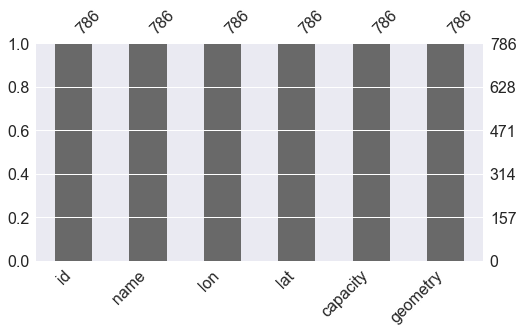

In [4]:
# Check for missings

import missingno as msno
msno.bar(stations, figsize=(8,4));

In [14]:
# Import hires data

hires = (
    pd.read_csv('data/cycle_hires/179JourneyDataExtract11Sep2019-17Sep2019.csv')
    .clean_names()
    .dropna()
    .drop_duplicates()
    .remove_columns(['rental_id', 'duration', 'bike_id'])
    .to_datetime('end_date', format='%d/%m/%Y %H:%M')
    .to_datetime('start_date', format='%d/%m/%Y %H:%M')
)

# Add station capacity

hires = (
    hires
    .merge(stations, left_on='startstation_id', right_on='id')
    .drop(columns=['id', 'name', 'geometry'])
    .rename(columns={'capacity':'startstation_capacity', 
                     'lon':'startstation_lon', 'lat':'startstation_lat'})
)

hires = (
    hires
    .merge(stations, left_on='endstation_id', right_on='id')
    .drop(columns=['id', 'name', 'geometry'])
    .rename(columns={'capacity':'endstation_capacity',
                     'geometry_x':'geometry', 
                     'lon':'endstation_lon', 'lat':'endstation_lat'})
)

hires = hires[hires['startstation_id'] != hires['endstation_id']]

print(hires.shape)
hires.head()

(238820, 12)


,end_date,endstation_id,endstation_name,start_date,startstation_id,startstation_name,startstation_lon,startstation_lat,startstation_capacity,endstation_lon,endstation_lat,endstation_capacity
0,2019-09-11 13:25:00,125,"Borough High Street, The Borough",2019-09-11 13:21:00,10,"Park Street, Bankside",51.505974,-0.092754,18,51.500695,-0.094524,21
1,2019-09-12 20:22:00,125,"Borough High Street, The Borough",2019-09-12 19:41:00,10,"Park Street, Bankside",51.505974,-0.092754,18,51.500695,-0.094524,21
2,2019-09-14 12:43:00,125,"Borough High Street, The Borough",2019-09-14 12:16:00,444,"Bethnal Green Garden, Bethnal Green",51.525680,-0.055312,24,51.500695,-0.094524,21
12,2019-09-12 22:35:00,125,"Borough High Street, The Borough",2019-09-12 22:11:00,428,"Exhibition Road, Knightsbridge",51.499917,-0.174554,20,51.500695,-0.094524,21
13,2019-09-12 08:51:00,125,"Borough High Street, The Borough",2019-09-12 08:40:00,270,"Kennington Lane Rail Bridge, Vauxhall",51.486343,-0.122492,31,51.500695,-0.094524,21


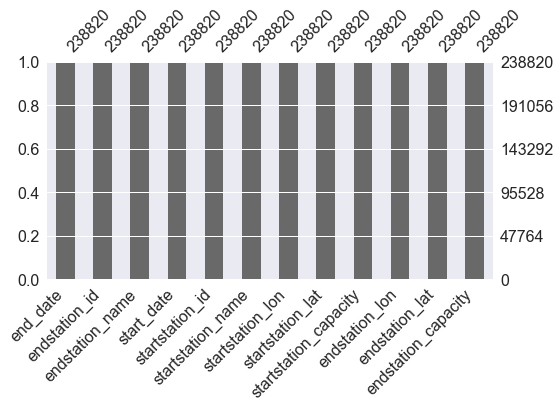

In [15]:
# Check for missings

msno.bar(hires, figsize=(8,4));

# Plot inflows and outflows

In [16]:
# This would probably be a nicer map background, check out.
# buildings = gpd.read_file('data/geo_data/OS OpenMap Local (ESRI Shape File) TQ/TQ_Building.shp')
# From: https://www.ordnancesurvey.co.uk/opendatadownload/products.html#OPROAD

In [17]:
def calc_flows(df):
    """
    Returnes a dataFrame with the number of outgoing
    and incoming bikes for each station.
    """
    outflow = (
        df.groupby('startstation_id')[['start_date']].count()
        .reset_index()
        .rename(columns={'startstation_id':'id', 'start_date':'out'})
    )
    inflow = (
        df.groupby('endstation_id')[['end_date']].count()
        .reset_index()
        .rename(columns={'endstation_id':'id', 'end_date':'in'})
    )
    return outflow.merge(inflow, on='id', how='inner')

# Calculate morning and evening flows on weekdays

weekdays = hires[hires['start_date'].dt.dayofweek < 5]

mornings = weekdays[weekdays['start_date'].dt.hour.between(6,10)]
morning_flows = calc_flows(mornings)
morning_flows = stations.merge(morning_flows, on='id', how='inner')

evenings = weekdays[weekdays['start_date'].dt.hour.between(16,20)]
evening_flows = calc_flows(evenings)
evening_flows = stations.merge(evening_flows, on='id', how='inner')

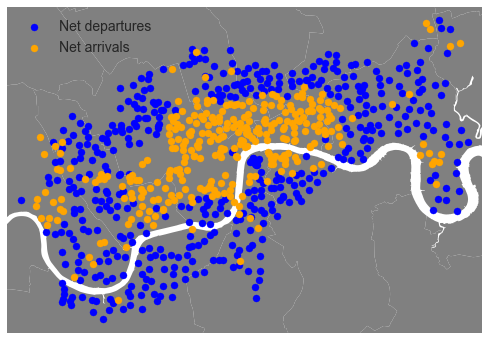

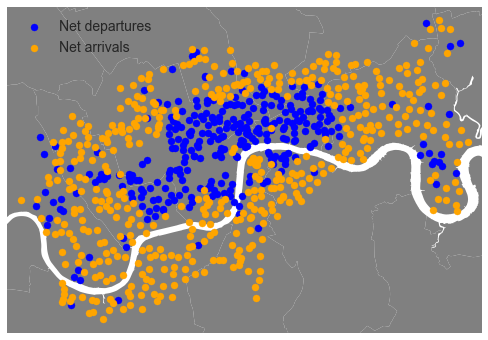

In [18]:
from toolbox.toolbox import get_borough_boundaries

def make_flow_plot(df):
    boundaries = get_borough_boundaries()

    # Ensure crs are consistent
    df = df.to_crs(boundaries.crs)
    
    labels = {True: 'Net departures', False:'Net arrivals'}
    df['net'] = (df['out'] - df['in'] > 0).map(labels)

    fig, ax = plt.subplots(1, 1, figsize=(12,6))

    xmin = df['geometry'].bounds.minx.min() - 500
    xmax = df['geometry'].bounds.maxx.max() + 500
    ymin = df['geometry'].bounds.miny.min() - 500
    ymax = df['geometry'].bounds.maxy.max() + 500

    clist = ['blue', 'orange']
    
    base = boundaries.plot(ax=ax, color='gray')
    for i, v in enumerate(df['net'].unique()):
        df[df['net'] == v].plot(ax=base, marker='o', 
                                c=clist[i], label=v,
                                markersize=50, legend=True)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis('off')
    ax.legend(fontsize=14)

make_flow_plot(morning_flows)
make_flow_plot(evening_flows)

In [55]:
morning_flows

,id,name,lon,lat,capacity,geometry,out,in
0,1,"River Street , Clerkenwell",51.529163,-0.109971,19,POINT (-0.10997 51.52916),40,17
1,2,"Phillimore Gardens, Kensington",51.499607,-0.197574,37,POINT (-0.19757 51.49961),46,88
2,3,"Christopher Street, Liverpool Street",51.521284,-0.084606,32,POINT (-0.08461 51.52128),60,263
3,4,"St. Chad's Street, King's Cross",51.530059,-0.120974,23,POINT (-0.12097 51.53006),78,24
4,5,"Sedding Street, Sloane Square",51.493130,-0.156876,27,POINT (-0.15688 51.49313),82,172
...,...,...,...,...,...,...,...,...
765,834,"Gas Holders, Battersea Park",51.477966,-0.147857,26,POINT (-0.14786 51.47797),74,24
766,835,"Farringdon Street, Holborn",51.516785,-0.104948,25,POINT (-0.10495 51.51678),12,136
767,836,"York Way, Kings Cross",51.541596,-0.125441,24,POINT (-0.12544 51.54160),77,19
768,838,"Fore Street Avenue, Guildhall",51.518093,-0.091402,25,POINT (-0.09140 51.51809),22,140


# Misc.

In [ ]:
# Load cycle hire data from website

url = 'https://cycling.data.tfl.gov.uk/usage-stats/'
csv_list = ['179JourneyDataExtract11Sep2019-17Sep2019.csv']

url_list = [url + f for f in csv_list]
df_list = (pd.read_csv(f) for f in url_list)

df = (
    pd.concat(df_list)
#     ...
)

In [ ]:
# Old choropleth graph

# Here, stations seem to be Tube stations, even though they are saved in cycle parking stations file. 

# Load data and combine borough boundaries and profiles

from toolbox.toolbox import get_stations_data
from toolbox.toolbox import get_borough_boundaries
from toolbox.toolbox import get_borough_profiles

stations = get_stations_data()
boundaries = get_borough_boundaries().set_index('name')
profiles = get_borough_profiles().set_index('area_name')

boroughs = boundaries.join(profiles)
boroughs.head()


# Produce graph

import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable

variable = 'population'

# Ensure that maps have the same crs
boroughs = boroughs.to_crs(stations.crs)

# Create borough map as base
fig, ax = plt.subplots(1, 1, figsize=(16,8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
base = boroughs.plot(column=variable, cmap='Blues', ax=ax, cax=cax,
                     legend=True, legend_kwds={'label':variable})

# Plot stations on top of base
stations.plot(ax=base, marker='o', color='red', markersize=2)

ax.axis('off')
ax.set_title('Title', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: London Datastore, 2014',xy=(0.1, .08),  
            fontsize=12, color='#555555',
            xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', );

# Inspirations

Based on ideas and code [here](https://github.com/ilkarman/Movement-Visualisations) and [here](https://github.com/charlie1347/TfL_bikes)